## Uber Code

## Model Description 
This code brings together all of the flopy components that we will learn over the term.  You can turn elements on and off using switches defined at the top of the code
Parameters and boundary condition values are defined below 

#### Dimensions: 
- 50 by 50 by nlay (default is one)
- dx = dy = 100 m
- dz = 100 m  

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x, y and z 
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient = 0.001  

#### Boundary Conditions: 
 - Right boundary is a constant head of 70 m relative to the datum, which is located at the bottom of the domain.
 - Left boundary is a constant head of 90 m relative to the datum, which is located at the bottom of the domain. 
 - Recharge occurs at a rate of 1E-5 m/d uniformly across the domain
 - ET occurs in the left half of the domain (0 < x <= 50) at a rate of 3E-6 m/d

#### Initial Conditions: 
 - For transient solutins, set the initial head to 70 everywhere and replaced it with an initial steady state stress period

# --------------------------------------------------------

## Package Organization

#### Create model object
#### Set up discretization
#### Define boundary conditions
#### Distribute hydraulic properties as layers or over grid
#### Define output preferences
#### Choose solver
#### Add wells
#### Add Recharge
#### Add ET
#### Define the model components to run
#### Run the model
#### Create plots








## Setup the python environment

In [71]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 

## User input

In [81]:
modelname = "UberCode"

moddir="D:/tyferre/frequent/GitHub/Git_GW_Modeling_Spring2021/Course_Materials/Assignments/mf2005"                     # home computer
# moddir="C:/Users/tyfer\Documents/frequent/GitHub/Git_GW_Modeling_Spring2021/Course_Materials/Assignments/mf2005"     # school computer

nrow = 50                                                                                                              # number of rows
ncol = 50                                                                                                              # number of columns
nlay = 1                                                                                                               # number of layers

dx= 100                                                                                                                # width of grid cells in x direction 
dy= 100                                                                                                                # width of grid cells in y direction 

transient_model = 1                                                                                                    # set to 1 to run a transient model

sp_peryr = 2                                                                                                           # periods for seasonality (two stress periods per year)
sp1_len = 90                                                                                                           # Length of stress period 1 in days
sp2_len = 360-sp1_len                                                                                                  # Length of stress period 2 in days
sim_years = 100                                                                                                        # number of years for transient simulation 

lboundary_head = 90                                                                                                    # constant head on left boundary 
rboundary_head = 70                                                                                                    # constant head on right boundary 

progress_check = 1                                                                                                     # set to zero to skip plots used to check the model when setting it up

use_layers = 0                                                                                                         # set to zero to define cell-by-cell values, set to 1 to define properties by layer


## Create the model object

In [73]:

m = flopy.modflow.Modflow(modelname, exe_name = moddir)


## Setup the discretization (DIS package)

For more details on DIS package inputs refer to : https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfdis.html 


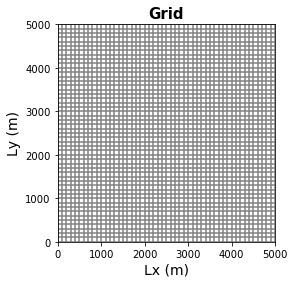

In [74]:
# ------------------------------------------------------------------------------------------
# Spatial discretization
# ------------------------------------------------------------------------------------------

Lx = ncol*dx                                      # width of domain in x
Ly = nrow*dy                                      # width of domain in y
ztop = 100.                                       # top elevation 
zbot = 0.                                         # bottom elevation

dz = (ztop - zbot) / nlay                         # cell height in z direction

domain_centerpt = (0, int(nrow/2), int(ncol/2))


# ------------------------------------------------------------------------------------------
# Temporal discretization
# ------------------------------------------------------------------------------------------

if transient_model == 1:

    nper = int(sp_peryr*sim_years + 1)                                   # total number of stress periods the +1 is for the steady state start

    steady = np.ones(nper, dtype=bool)*False                             # steady-state or transient flag for each stress period (boolean array)
    steady[0] = True                                                     # initial stress period is steady-state

    perlen=np.tile([sp1_len, sp2_len],sim_years)                         # make an array of period lengths
    perlen=np.append(10,perlen)                                          # add a period of length 10 at the start for the steady state simulation

    nstp=perlen/30                                                       # set monthly time steps per stress period to get monthly results
    nstp[0]=1                                                            # for the steady state solution we just want one output
    nstp = nstp.astype(int)

    elyears = (np.cumsum(perlen)-perlen[0])/360
 
    H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)               # float array (i.e. decimal), sets all heads to 1.0
    H_init[:, :, :] = rboundary_head                                     # set all values to uniform initial condition
    H_init[:, :, 0] = lboundary_head                                     # replace first (left) col with desired head value


else:

    nper = 1                                                             # steady state has only one stress period 
    steady = [True]                                                      


# ------------------------------------------------------------------------------------------
# Create flopy discretization object, length and time are meters (2) and days (4)
# ------------------------------------------------------------------------------------------

dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=zbot, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady)


# ------------------------------------------------------------------------------------------
# Progress check - plot the model grid
#     For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html
# ------------------------------------------------------------------------------------------

if progress_check==1:                                                #use flopy to plot the model grid
    modelmap = flopy.plot.PlotMapView(model=m, layer=0)
    grid = modelmap.plot_grid() 
    plt.xlabel('Lx (m)',fontsize = 14)
    plt.ylabel('Ly (m)',fontsize = 14)
    plt.title('Grid', fontsize = 15, fontweight = 'bold')
    plt.show()



## Setup constant head boundaries, active cells and initial heads (BAS Package)

For more details on the BAS package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbas.html

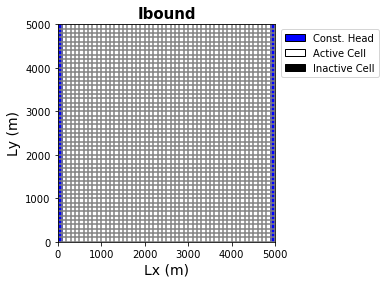

In [75]:
# ------------------------------------------------------------------------------------------
# Define the cell activities and set left/right constant head boundary conditions
# ------------------------------------------------------------------------------------------

ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) # integer array of dim (z,y,x), makes all cells active by setting all equal to 1     
ibound[:,:,0] = -1          # replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 
ibound[:,:,-1] = -1          # replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head 


# ------------------------------------------------------------------------------------------
# Define initial head values
#     These will be the defined head values on Type I boundaries that don't vary in time
# ------------------------------------------------------------------------------------------

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = 50    # set all values to uniform initial condition
H_init[:, :, -1] = 30    #replace last (right) col with desired head value


# ------------------------------------------------------------------------------------------
# Create flopy bas object
# ------------------------------------------------------------------------------------------

bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)


# ------------------------------------------------------------------------------------------
# Progress check - plot the boundary conditions on the grid
#     For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html
# ------------------------------------------------------------------------------------------

if progress_check==1:                                                #use flopy to plot the model grid
    modelmap = flopy.plot.PlotMapView(model=m, layer=0)
    grid = modelmap.plot_grid()
    ib = modelmap.plot_ibound()
    plt.xlabel('Lx (m)',fontsize = 14)
    plt.ylabel('Ly (m)',fontsize = 14)
    plt.title('Ibound', fontsize = 15, fontweight = 'bold')
    plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                    mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                    mp.patches.Patch(color='black',label='Inactive Cell',ec='black')],
                    bbox_to_anchor=(1.5,1.0))
    plt.show(modelmap)



## Setup Layer Properties  (LPF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mflpf.html

## Or setup Cell-byCell Properties  (BCF Package)

For more details on LPF package see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfbcf.html

got here


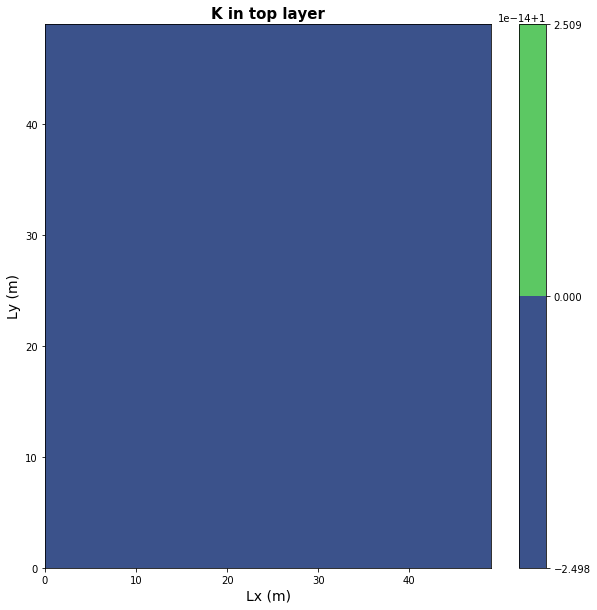

In [87]:
# WHY ARE THE K VALUES SET AS NCOL, NROW, NLAY INSTEAD OF NLAY, NCOL, NROW LIKE EVERYTHING ELSE??



if use_layers ==1:    # define properties by layer

    K_horiz = 1.    #horizontal hydraulic conductivity 
    K_vert = 1    #assign vertical hydraulic conductivity (along z axis)
    n = 0.35        #assign porosity
    Ss = 0.001      #assign storage coefficient
    Sy = 0.3        #assign specific yield
    uncnf = 1       #0=confined, >0 = unconfined

    # assigns horizontal and vertical Ks and saves cell-by-cell budget data
    lpf = flopy.modflow.ModflowLpf(m, laytyp=uncnf, hk=K_horiz, 
                                   vka=K_vert, ss=Ss,
                                   sy=Sy,storagecoefficient=True, ipakcb=53) 

else:
    K_vals = np.zeros((ncol,nrow,nlay))
    K_vals[:,:,:] = 1             # homogeneous background hydraulic conductivity 
    #K_vals[10:15,10:15,:] = 0.1   # low K inclusion

    n = 0.35        #assign porosity
    Ss = 0.001      #assign storage coefficient
    Sy = 0.3        #assign specific yield
    uncnf = 0       #0=confined, >0 = unconfined


# ------------------------------------------------------------------------------------------
# Progress check - plot the K distribution in selected layer if cell-by-cell definition used
#     For help on this function see: https://flopy.readthedocs.io/en/3.3.2/source/flopy.plot.plotutil.html
# ------------------------------------------------------------------------------------------

    if progress_check==1:                                                # use flopy to plot the model grid
        layer_to_plot = 0
        fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
        plt.xlabel('Lx (m)',fontsize = 14)
        plt.ylabel('Ly (m)',fontsize = 14)
        plt.title('K in top layer', fontsize = 15, fontweight = 'bold')
        plt.contourf(K_vals[:,:,layer_to_plot])
        plt.colorbar()
        plt.show()



#### 5b.2 Make BCF object

In [57]:
#assigns horizontal and vertical Ks and saves cell-by-cell budget data
bcf = flopy.modflow.ModflowBcf(m, ipakcb=53, intercellt=0, laycon=3, trpy=1.0, hdry=-1e+30, iwdflg=0, wetfct=0.1, iwetit=1, ihdwet=0, tran=1.0, hy=K_vals[:,:,0], vcont=1.0, sf1=Ss, sf2=Sy, wetdry=-0.01, extension='bcf', unitnumber=None, filenames=None) 


## 6. Setup outputs by stress period (OC Package)
For more details on OC Package: https://flopy.readthedocs.io/en/3.3.2/source/flopy.modflow.mfoc.html

#### 6.1 Setup outputs

In [58]:
#create oc stress period data - save for each time step in each stress period. 
oc_spd = {}
for kper in range(nper):  
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
# print("oc stress period data: \n", oc_spd)


#### 6.2 Make OC object 

In [59]:
oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

## 7. Set the numerical solver (PCG Package)

We are using the Preconditioned Conjugate Gradient package:

Additionally, MODFLOW online describes these solvers: https://water.usgs.gov/ogw/modflow/MODFLOW-2005-Guide/index.html?oc.htm

And Flopy documents its communication with the PCG MODFLOW package: http://modflowpy.github.io/flopydoc/mfpcg.html

#### 7.1 Make the PCG object

In [60]:
pcg = flopy.modflow.ModflowPcg(model=m)

## 8. Add wells for the constant flux boundary (WEL Package)
For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfwel.html

#### 8.1 Setup the well parameters (use this to set a defined flux boundary)

In [61]:
#Setup alternating pumping values
well_loc = [0, 20, 20]
Q1 = -500
Q2 = 0
Q_val=np.tile([Q1, Q2],sim_years)
Q_val=np.append(0,Q_val) # add a period of length 10 at the start for the steady state simulation
                      
Q = {}
for p in range(0,nper):    #loop over stress periods
    Q[p]=Q_val[p]

well_spd = {}                                                                                                     # create empty dictionary for well info
for per in range(nper):                                                                                       # transient models, iterate over stress periods to assign well stresses
    well_spd[per] = [[well_loc[0], well_loc[1], well_loc[2], Q_val[per]]]     # assign well coord & pump rate for each stress period

print(well_spd)

{0: [[0, 20, 20, 0]], 1: [[0, 20, 20, -500]], 2: [[0, 20, 20, 0]], 3: [[0, 20, 20, -500]], 4: [[0, 20, 20, 0]], 5: [[0, 20, 20, -500]], 6: [[0, 20, 20, 0]], 7: [[0, 20, 20, -500]], 8: [[0, 20, 20, 0]], 9: [[0, 20, 20, -500]], 10: [[0, 20, 20, 0]], 11: [[0, 20, 20, -500]], 12: [[0, 20, 20, 0]], 13: [[0, 20, 20, -500]], 14: [[0, 20, 20, 0]], 15: [[0, 20, 20, -500]], 16: [[0, 20, 20, 0]], 17: [[0, 20, 20, -500]], 18: [[0, 20, 20, 0]], 19: [[0, 20, 20, -500]], 20: [[0, 20, 20, 0]], 21: [[0, 20, 20, -500]], 22: [[0, 20, 20, 0]], 23: [[0, 20, 20, -500]], 24: [[0, 20, 20, 0]], 25: [[0, 20, 20, -500]], 26: [[0, 20, 20, 0]], 27: [[0, 20, 20, -500]], 28: [[0, 20, 20, 0]], 29: [[0, 20, 20, -500]], 30: [[0, 20, 20, 0]], 31: [[0, 20, 20, -500]], 32: [[0, 20, 20, 0]], 33: [[0, 20, 20, -500]], 34: [[0, 20, 20, 0]], 35: [[0, 20, 20, -500]], 36: [[0, 20, 20, 0]], 37: [[0, 20, 20, -500]], 38: [[0, 20, 20, 0]], 39: [[0, 20, 20, -500]], 40: [[0, 20, 20, 0]], 41: [[0, 20, 20, -500]], 42: [[0, 20, 20, 0]], 

#### 8.2 Make the WEL object

In [62]:
wel = flopy.modflow.mfwel.ModflowWel(m, stress_period_data=well_spd)  #create object for WEL package

##9. Add recharge (RCH Package)

For more details on the WEL package see: http://modflowpy.github.io/flopydoc/mfrch.html

#### 9.1 Setup recharge value

In [63]:
#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol) - backgroun ET is zero everywhere
recharge = 1e-4 #m/day                          
rech_zone[:,:] = recharge

rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_zone, ipakcb=53)     #create rch object


9.2 Add evapotranspiration

In [64]:
# ET - this is set up to show how you would add time-varying recharge in a localized area
ET_val1 = 0 #m/day
ET_val2 = 0 #m/day
ET_locxy=[[400, 900], [1500, 1600]] #lower left and upper right corners of ET in xy coordinate
extinction_depth = 50

ET_rows=(np.floor(nrow-ET_locxy[1][1]/dy),np.floor(nrow-ET_locxy[0][1]/dy)) #convert the y locations to rows
ET_cols=(np.floor(ET_locxy[0][0]/dx),np.floor(ET_locxy[1][0]/dx)) #convert the y locations to rows
ET_centerpt=(0, int(np.mean(ET_rows)),int(np.mean(ET_cols)))
ET_zone = np.zeros((nlay,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,int(ET_rows[0]):int(ET_rows[1]), int(ET_cols[0]):int(ET_cols[1])] = ET_val2  # assign ET rate to the ET zone

#Setup alternating ET values
ET_val=np.tile([ET_val1, ET_val2],sim_years)
ET_val=np.append(ET_val1,ET_val) # add a period of length 10 at the start for the steady state simulation
print('ET_val',ET_val)
                      
ET = {}
for p in range(0,nper):    #loop over stress periods
    ET[p]=ET_zone*ET_val[p]

evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET, exdp=extinction_depth, ipakcb=53) 



ET_val [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


## 10. Write inputs and run the model 

#### 10.1 Write Inputs

In [65]:
m.write_input()    #uses the package objects created above to actually write the text files, 
                    #and saves to folder that this script is in
                    #after this step you should see the files appear in your folder


#### 10.2 Run the model

In [66]:
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following  executable to run the model: D:/tyferre/frequent/GitHub/Git_GW_Modeling_Spring2021/Course_Materials/Assignments/mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.11.00 8/8/2013                        

 Using NAME file: UberCode.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/03/21 11:30:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     3    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     4    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     5    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     6    Time step:     1    Ground-Water Flow Eqn.
 Solving:  Stress period:     7    Time step:     1    Ground-Water F

## 11. Plot the results  

#### 11.1 Read in the model outputs

For information on binary files see: http://modflowpy.github.io/flopydoc/binaryfile.html 

For information on flow budget files see: 
http://modflowpy.github.io/flopydoc/binaryfile.html#flopy.utils.binaryfile.CellBudgetFile



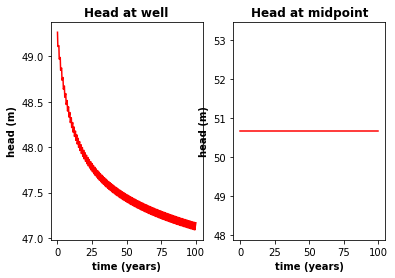

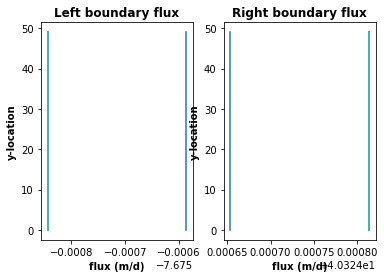

In [67]:
# Read the heads 
# headobj = bf.HeadFile(modelname+'.hds')    #reads the binary head file
# times = headobj.get_times()                #returns a list of timesteps
# head = headobj.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)

# head = headobj.get_data

hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
times = hds.get_times() # returns a list of timesteps

#extract binary data from head file
head = {} #create dictionary to store head data at end of each stress period
frf = {} #create dictionary to store flows through right cell face at end of each stress period
fff = {} #create dictionary to store flows through front cell face at end of each stress period
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds') #get head data as python object
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc') #get flow data as python object

#get data from python objects
head = []
headarray=np.zeros((len(times),ncol,nrow))
frf=np.zeros((len(times),ncol,nrow))
fff=np.zeros((len(times),ncol,nrow))
rowcounter=-1
for i in times:
    rowcounter+=1
    temphead = headobj.get_data(totim=i) #append heads to head list for each stress per
    headarray[rowcounter,:,:] = temphead
    tempfrf = np.squeeze(budgobj.get_data(text='flow right face',totim=i))
    # print(tempfrf)
    frf[rowcounter,:,:] = tempfrf
    tempfff = np.squeeze(budgobj.get_data(text='FLOW FRONT FACE',totim=i))
    fff[rowcounter,:,:] = tempfff


# extract and plot head time series at specific points
time_series1 = headarray[:,domain_centerpt[1],ET_centerpt[2]]
time_series1 = np.round(time_series1,4)
time_series2 = headarray[:,well_loc[1],well_loc[2]]

plt.subplot(1, 2, 1)
plt.title("Head at well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(elyears, time_series2, 'r-') #plot the time series with points at each record

plt.subplot(1, 2, 2)
plt.title("Head at midpoint",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(elyears, time_series1, 'r-') #plot the time series with points at each record
plt.show()

# extract and plot boundary flux time series
leftdb_time_series = frf[:,:,0]
rightdb_time_series = frf[:,:,-2]

plt.subplot(1, 2, 1)
plt.title("Left boundary flux",fontweight='bold')
plt.xlabel('flux (m/d)',fontweight='bold')
plt.ylabel('y-location',fontweight='bold')
plt.plot(np.rot90(leftdb_time_series[1:,:], k=1), np.arange(nrow)) #plot the time series with points at each record

plt.subplot(1, 2, 2)
plt.title("Right boundary flux",fontweight='bold')
plt.xlabel('flux (m/d)',fontweight='bold')
plt.ylabel('y-location',fontweight='bold')
plt.plot(np.rot90(rightdb_time_series[1:,:], k=1), np.arange(nrow)) #plot the time series with points at each record
plt.show()



##### Write Heads as csv

In [33]:
# with open('FP_heads.csv', 'w', newline='') as csvfile:  #creates an empty csv file called FP_heads
#     writer = csv.writer(csvfile, delimiter=',')        
#     for i in range(len(head[0,:,0])):                    #writes each row
#         writer.writerow(head[0,i,:])


##### Read the Water Balance and use it to find distribution of fluxes along boundary

', b'', b'')
(1, 159, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 159., b'', b'', b'', b'')
(1, 160, b'         STORAGE', 50, 50, -1, 1, 1., 1., 160., b'', b'', b'', b'')
(1, 160, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 160., b'', b'', b'', b'')
(1, 160, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 160., b'', b'', b'', b'')
(1, 160, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 160., b'', b'', b'', b'')
(1, 160, b'              ET', 50, 50, -1, 3, 1., 1., 160., b'', b'', b'', b'')
(1, 160, b'        RECHARGE', 50, 50, -1, 3, 1., 1., 160., b'', b'', b'', b'')
(1, 161, b'         STORAGE', 50, 50, -1, 1, 1., 1., 161., b'', b'', b'', b'')
(1, 161, b'   CONSTANT HEAD', 50, 50, -1, 2, 1., 1., 161., b'', b'', b'', b'')
(1, 161, b'FLOW RIGHT FACE ', 50, 50, -1, 1, 1., 1., 161., b'', b'', b'', b'')
(1, 161, b'FLOW FRONT FACE ', 50, 50, -1, 1, 1., 1., 161., b'', b'', b'', b'')
(1, 161, b'              ET', 50, 50, -1, 3, 1., 1., 161., b'', b'', b'', b'')
(1, 161, b'        RECHARGE', 50, 50, -

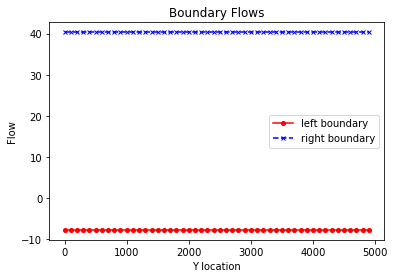

In [68]:
budgobj = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    

dummy = budgobj.list_records()

kstpkper_list = budgobj.get_kstpkper()          #returns a list of stress periods & timesteps
frf = budgobj.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff = budgobj.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells     

flux_vals=np.squeeze(frf)
leftflux = flux_vals[:,0]
rightflux = flux_vals[:,-2]

bdryflux_fig = plt.figure() 
x=np.arange(0,ncol*dx,dx) 
plt.plot(x,leftflux,marker='o', color='red', markersize=4, linestyle='-',label="left boundary")
plt.plot(x,rightflux,marker='x', color='blue', markersize=4, linestyle='--',label="right boundary")
plt.xlabel('Y location')
plt.ylabel('Flow')
plt.title("Boundary Flows")
plt.legend()
plt.show()




#### 11.2 Evaluate the head gradients

In [69]:
# head_fig = plt.figure() 
# x=np.arange(100,2600,100) 
# y=head[0,12,:]
# plt.plot(x,y,marker='o', color='mediumvioletred', markersize=4, linestyle='--')
# plt.xlabel('X location')
# plt.ylabel('Head')
# plt.title("Head along row 12")
# #plt.axvline(x=1200)

# #Save figure
# # plt.savefig('Head_Transect.png') #save figure as a png

# hgrad=(head[0,5,0]-head[0,5,-1])/Lx
# print("Head Gradient", hgrad, "m/m") 

#### 11.3 3D plot of heads

In [70]:
#create 3d figure
fig_3d = plt.figure(figsize=(12,5))
ax = fig_3d.gca(projection='3d')

#set X, Y, Z variables for 3d plot to be our model domain and head solution
X = np.arange(0,Lx,dx)
Y = np.arange(0,Ly,dy)
X, Y = np.meshgrid(X, Y)
Z = np.flipud(head[0])

#create surface and labels
surf = ax.plot_surface(X,Y,Z, cmap = 'viridis', linewidth=0, label='head')
fig_3d.colorbar(surf,shrink=0.5,aspect=5).set_label('Head (m)',fontsize=10,fontweight='bold')
ax.set_xlabel('Lx (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Ly (m)', fontsize=15, fontweight='bold')
ax.set_title('Steady-State Model Head Profile', fontsize=15, fontweight='bold')
# plt.savefig('BoxModel_Surface1.png') 
#plt.show(surf)

IndexError: list index out of range

In [38]:
#create 2d figure - note, axes relate to well being defined as layer, row, column, flux
plt.contour(head[0])
plt.xlabel("column")
plt.ylabel("row")
plt.title("Plan View Head Contours")
plt.show()

# calculate linear head drop (no pumping)
bkgnd_head=np.linspace(20,10,25)
bkgnd_head=np.tile(bkgnd_head,(25,1))
plt.contour(bkgnd_head-head[0])
plt.xlabel("column")
plt.ylabel("row")
plt.title("Plan View Drawdown")
plt.show()





IndexError: list index out of range

####  11.4 Contour Head plot

IndexError: list index out of range

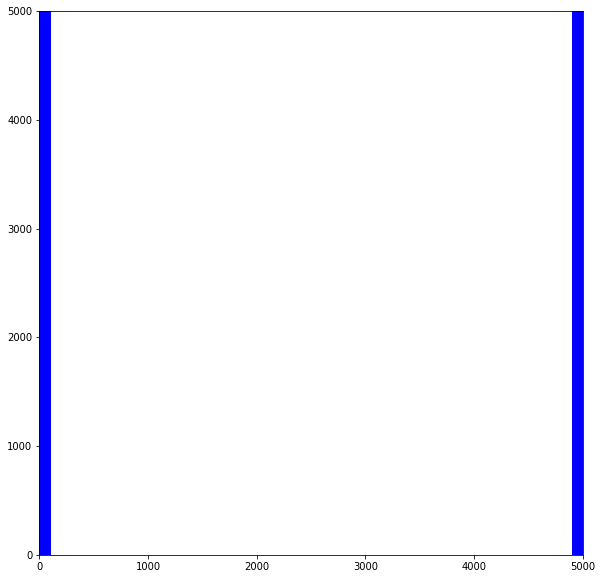

In [39]:
#plot first contour plot
fig1 = plt.figure(figsize=(10,10)) #create 10 x 10 figure
modelmap = flopy.plot.PlotMapView(model=m, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head[0].min(),head[0].max(),11) #set contour levels for contouring head
head_contours = modelmap.contour_array(head, levels=contour_levels) #create head contours   
flows = modelmap.plot_discharge(frf[0], fff[0], head=head) #create discharge arrows

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Steady-State Model, Flow(m^3/d) and Head(m) Results', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
# plt.savefig('BoxModel_vectors.png')   
#plt.show(modelmap)